In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
from utils import get_data_per_anchor, spatial_plot
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import os
import warnings
from micromlgen import port
import m2cgen as m2c
warnings.filterwarnings("ignore")

In [21]:
params = {
    "test_size":0.33,
    "random_state":42,
    "splits":3,
    
}

In [22]:
df = pd.read_pickle("raw_IQ.pkl")
df.sort_values(['point', 'anchor', 'room', 'channel'], inplace=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [23]:
def iq_processing(data):
    
    """
    Input: Data
    Output: Processed Data

    Processing: Power Scaling, IQ shifting
    """

    cols_real = ['pdda_input_real_{}'.format(x+1) for x in range(5)]
    cols_imag = ['pdda_input_imag_{}'.format(x+1) for x in range(5)]

    iq_values = pd.DataFrame(data['pdda_input_real'].tolist(), columns=cols_real, index=data.index)
    iq_values[cols_imag] = pd.DataFrame(data['pdda_input_imag'].tolist(), columns=cols_imag, index=data.index)
    
    phase = pd.DataFrame(np.arctan2(iq_values['pdda_input_imag_1'],iq_values['pdda_input_real_1']), columns=['phase_1'])
    
    cos = np.cos(phase).values.ravel()
    sin = np.sin(phase).values.ravel()
    
    out = data.copy()
    iq_ref = np.abs(iq_values[f'pdda_input_real_1']*cos + iq_values[f'pdda_input_imag_1']*sin)
    for i in range(1,6):
        out[f'pdda_input_real_{i}'] = (iq_values[f'pdda_input_real_{i}']*cos + iq_values[f'pdda_input_imag_{i}']*sin)
        out[f'pdda_input_imag_{i}'] = (-iq_values[f'pdda_input_real_{i}']*sin + iq_values[f'pdda_input_imag_{i}']*cos)
        iq_ref +=  iq_values[f'pdda_input_real_{i}']**2 + iq_values[f'pdda_input_imag_{i}']**2

    power_norm =  StandardScaler().fit_transform((out['reference_power'] + out['relative_power']).values.reshape(-1,1))/10
    
    out.insert(25, 'power', power_norm)
    out.insert(24, 'iq_ref', iq_ref)
    out.drop(columns=['pdda_input_imag_1', 'pdda_input_real', 'pdda_input_imag'], inplace=True)
    return out

In [24]:
features = ['power', 'pdda_input_real_1', 'pdda_input_real_2', 'pdda_input_imag_2', 'pdda_input_real_3', 'pdda_input_imag_3', 'pdda_input_real_4', 'pdda_input_imag_4',
           'pdda_input_real_5', 'pdda_input_imag_5']
# theta does not change, make predictions for phi only, azimuth angles 
# predict only for phi, 
targets = ['true_phi']
location = ['x_tag', 'y_tag']
pdda_angle = ['pdda_phi']
point = ['point']

In [25]:
def scale(df):
    """scale dataset with mean=0, std=1"""
    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])
    return df

In [26]:
def select_polarity(df):
    """"rssi signals closer to 0, represent the better quality of signal"""
    tmp = df.sort_values(['point', 'anchor', 'channel', 'room'])
    tmp['mask'] = tmp['reference_power'] + df['relative_power']
    tmp = tmp.sort_values(['point', 'anchor', 'channel', 'room', 'mask'])
    tmp = tmp.drop_duplicates(subset=['point', 'anchor', 'channel', 'room'], keep='last')
    return tmp

In [27]:
def select_random_channel(df):
    mid_concrete_random = pd.DataFrame()
    for room in df.room.unique():
        room_df = df.loc[df['room'] == room]
        for anchor in df.anchor.unique():
            anchor_df = room_df.loc[room_df['anchor'] == anchor]
            grouped = anchor_df.groupby(['point'],as_index=False)
            for group, tdf in grouped:
                random_selection = tdf.sample(n=1,random_state=42)
                mid_concrete_random = pd.concat([mid_concrete_random, random_selection])
    return mid_concrete_random

In [28]:
# df_random.to_pickle('no_.pkl')

In [29]:
def train(df, models, metrics):
    results = pd.DataFrame()
    true_phi = []
    model_preds = []
    pdda_preds = []
    anchor_val = []
    x_loc = []
    y_loc = []
    pts = []
    flag = True
    trained_models = {}
    anchor_mae = {}
    pdda_error = []
    m_preds = {}
    for model in models:
        print(str(model))
        for anchor in [1.0,2.0,3.0,4.0]:
            avg_mae = 0
            avg_pdda = 0
            anchor_df = df.loc[df['anchor'] == anchor]
            X = anchor_df[features].values
            y = anchor_df[targets].values
            gss = GroupShuffleSplit(n_splits=params["splits"], test_size=params["test_size"], random_state=params["random_state"])
            fold = 1
            for train_idx, test_idx in gss.split(X, y, groups=anchor_df.point):
                temp = pd.DataFrame()
                train = anchor_df.iloc[train_idx]
                test = anchor_df.iloc[test_idx]
                assert round(test.shape[0]/(train.shape[0]+test.shape[0]), 2) == params["test_size"]
                assert len(set(train.point) & set(test.point)) == 0
                X_train = train[features].values
                y_train = train[targets].values
                X_test = test[features].values
                test_location = test[location].values
                pdda_result = test[pdda_angle].values
                y_test = test[targets].values
                points = test[point].values
                

                # learn the trainer on the train set and apply for testing set
                regr = model
                regr.fit(X_train,y_train)
                if str(model) not in trained_models:
                    if str(model).split("(")[0] != "XGBRegressor":
                        trained_models[str(model)] = regr
                    else:
                        trained_models["XGBRegressor"] = regr
                # trained_models.append(regr)
                predictions = regr.predict(X_test)
                # print(predictions)
    
                # need pointwise error for plotting using spatial_plot function
                for i in range(len(predictions)):
                    model_preds.append(predictions[i])
                    # predictions.append(mean_absolute_error(y_test[i], temp))
                    pdda_preds.append(pdda_result[i][0])
                    true_phi.append(y_test[i][0])
                    pts.append(points[i][0])
                    x_coordinate, y_coordinate = test_location[i]
                    x_loc.append(x_coordinate)
                    y_loc.append(y_coordinate)
                    anchor_val.append(anchor)
                l_mae = mean_absolute_error(y_test.ravel(), predictions.ravel())
                pdda_mae = mean_absolute_error(y_test.ravel(), pdda_result.ravel())
                avg_mae += l_mae
                avg_pdda += pdda_mae
               
        
                # print(avg_mae)
            avg_mae = avg_mae/3
            avg_pdda = avg_pdda/3
            # print(avg_mae)
            if len(pdda_error) < 4:
                pdda_error.append(avg_pdda)
            model_name = str(model).split("(")[0]
            if model_name != 'XGBRegressor':
                model_name = str(model)
            if str(model_name) not in anchor_mae:
                anchor_mae[model_name] = [avg_mae]
            else:
                anchor_mae[model_name] += [avg_mae]
            # avg_mae.append(sum(errors)/len(errors))
            # temp = []

        
        
        # model_name = str(model).split("(")[0]
        # if model_name == 'XGBRegressor':
        #     results[model_name] = model_preds
        # else:
        #     results[str(model)] = model_preds
         
        if flag:
            temp['pdda'] = pdda_preds
            temp['true_phi'] = true_phi
            temp['x_loc'] = x_loc
            temp['y_loc'] = y_loc
            temp['point'] = pts
            temp['anchor'] = anchor_val
            results = pd.concat([results, temp])
            flag = False
            
        model_name = str(model).split("(")[0]
        if model_name != 'XGBRegressor':
            model_name = str(model)
        m_preds[model_name] = model_preds
        model_preds = []
        pdda_preds = []
        true_phi = []
        x_loc = []
        y_loc = []
        pts = []
        anchor_val = []
        # results = pd.concat([results, temp])
    for k,v in m_preds.items():
        results[k] = v
    return (results, anchor_mae, pdda_error, trained_models)

In [30]:
df.room.unique()

array(['testbench_01', 'testbench_01_furniture_high',
       'testbench_01_furniture_low', 'testbench_01_furniture_mid'],
      dtype=object)

In [31]:
mid = df[df['room'] == 'testbench_01_furniture_mid']
mid = iq_processing(mid)
mid = scale(mid)
mid = select_polarity(mid)
mid = select_random_channel(mid)

In [32]:
models = [RandomForestRegressor(), RandomForestRegressor(n_estimators=10),RandomForestRegressor(n_estimators=20), RandomForestRegressor(n_estimators=30), RandomForestRegressor(n_estimators=40), RandomForestRegressor(n_estimators=50),   
          RandomForestRegressor(n_estimators=10,max_depth=3), RandomForestRegressor(n_estimators=10,max_depth=5),RandomForestRegressor(n_estimators=10,max_depth=10),RandomForestRegressor(n_estimators=10,max_depth=15), RandomForestRegressor(n_estimators=10,max_depth=20), RandomForestRegressor(n_estimators=10,max_depth=25),RandomForestRegressor(n_estimators=10,max_depth=30),
          DecisionTreeRegressor(),  KNeighborsRegressor(), MLPRegressor(), SVR(), GradientBoostingRegressor(),xgb.XGBRegressor(),LinearRegression()]
metrics = [mean_absolute_error, r2_score]

In [33]:
def calculate_mae_errors(results):
    # calculate average mae errors over all anchors
    grouped = results.groupby(['point','anchor'],as_index=False)
    avg_errors = pd.DataFrame()

    for group, tdf in grouped:
        p_df = pd.DataFrame()
        maes_pdda = []
        maes_rf100 = []
        maes_rf10 = []
        maes_svr = []
        maes_lr = []
        
        maes_xgboost = []
        maes_dt = []
        x_locs = []
        y_locs = []
        maes_pdda.append(mean_absolute_error([np.mean(tdf['pdda'].values)], [tdf['true_phi'].values[0]]))

        maes_rf100.append(mean_absolute_error([np.mean(tdf['RandomForestRegressor()'].values)], [tdf['true_phi'].values[0]]))
        maes_rf10.append(mean_absolute_error([np.mean(tdf['RandomForestRegressor(n_estimators=10)'].values)], [tdf['true_phi'].values[0]]))
        maes_svr.append(mean_absolute_error([np.mean(tdf['SVR()'].values)], [tdf['true_phi'].values[0]]))
        maes_xgboost.append(mean_absolute_error([np.mean(tdf['XGBRegressor'].values)], [tdf['true_phi'].values[0]]))
        maes_dt.append(mean_absolute_error([np.mean(tdf['DecisionTreeRegressor()'].values)], [tdf['true_phi'].values[0]]))
        maes_lr.append(mean_absolute_error([np.mean(tdf['LinearRegression()'].values)], [tdf['true_phi'].values[0]]))
        x_locs.append(tdf['x_loc'].values[0])
        y_locs.append(tdf['y_loc'].values[0])

        p_df['MAE_pdda'] = maes_pdda
        p_df['MAE_LR'] = maes_lr
        p_df['MAE_SVR'] = maes_svr
        p_df['MAE_DT'] = maes_dt
        
        p_df['MAE_RF10'] = maes_rf10
        
        p_df['MAE_XGBoost'] = maes_xgboost

        p_df['MAE_RF100'] = maes_rf100
        p_df['x_loc'] = x_locs
        p_df['y_loc'] = y_locs

        avg_errors = pd.concat([avg_errors, p_df])
    return avg_errors
            


In [34]:
results.head()

NameError: name 'results' is not defined

In [ ]:
def calculate_mae(results):
    mae = {}
    # print(mean_absolute_error(results['pdda'], results['true_phi']))
    mae['pdda'] = mean_absolute_error(results['pdda'], results['true_phi'])
    mae['RF100'] = mean_absolute_error(results['RandomForestRegressor()'], results['true_phi'])
    mae['RF10'] = mean_absolute_error(results['RandomForestRegressor(n_estimators=10)'], results['true_phi'])
    # mae['RF20'] = mean_absolute_error(results['RandomForestRegressor(n_estimators=20)'], results['true_phi'])
    # mae['RF30'] = mean_absolute_error(results['RandomForestRegressor(n_estimators=30)'], results['true_phi'])
    # mae['RF40'] = mean_absolute_error(results['RandomForestRegressor(n_estimators=40)'], results['true_phi'])
    # mae['RF50'] = mean_absolute_error(results['RandomForestRegressor(n_estimators=50)'], results['true_phi'])
    
    # mae['RFm3'] = mean_absolute_error(results['RandomForestRegressor(max_depth=3, n_estimators=10)'], results['true_phi'])
    # mae['RFm5'] = mean_absolute_error(results['RandomForestRegressor(max_depth=5, n_estimators=10)'], results['true_phi'])
    # mae['RFm10'] = mean_absolute_error(results['RandomForestRegressor(max_depth=10, n_estimators=10)'], results['true_phi'])
    # mae['RFm15'] = mean_absolute_error(results['RandomForestRegressor(max_depth=15, n_estimators=10)'], results['true_phi'])
    # mae['RFm20'] = mean_absolute_error(results['RandomForestRegressor(max_depth=20, n_estimators=10)'], results['true_phi'])
    # mae['RFm25'] = mean_absolute_error(results['RandomForestRegressor(max_depth=25, n_estimators=10)'], results['true_phi'])
    # mae['RFm30'] = mean_absolute_error(results['RandomForestRegressor(max_depth=30, n_estimators=10)'], results['true_phi'])
    mae['Decision Tree'] = mean_absolute_error(results['DecisionTreeRegressor()'], results['true_phi'])
    mae['KNN'] = mean_absolute_error(results['KNeighborsRegressor()'], results['true_phi'])
    mae['MLP'] = mean_absolute_error(results['MLPRegressor()'], results['true_phi'])
    mae['gb'] = mean_absolute_error(results['GradientBoostingRegressor()'], results['true_phi'])
    mae['XGBoost'] = mean_absolute_error(results['XGBRegressor'], results['true_phi'])
    mae['SVR'] = mean_absolute_error(results['SVR()'], results['true_phi'])
    # mae['Linear Regression'] = mean_absolute_error(results['LinearRegression()'], results['true_phi'])
    res = pd.DataFrame.from_dict(mae, orient="index")
    return res

In [35]:
high_furniture = calculate_mae(results)


In [304]:
# # pdda, rf100, rf10, decision tree, svr,  xgboost, lr, aoanet
# # avg mae errors for each envirnment averaged over all anchors
# results, anchor_mae, pdda_error, trained_models = train(mid, models, metrics)

# pdda_error = np.asarray(pdda_error).mean()
# maes = {}
# for k,v in anchor_mae.items():
#     maes[k] = np.asarray(v).mean()


# models = ['RandomForestRegressor()', 'RandomForestRegressor(n_estimators=10)', 'DecisionTreeRegressor()', 'SVR()', 'XGBRegressor', 'LinearRegression()']
# for model in models:
#     print(maes[model])
    
# no_furniture =  [8.53, 5.43, 5.78, 7.21, 8.58, 5.72, 9.40, 4.97]
# low_furniture = [8.47, 5.56, 5.85, 7.52, 8.68, 5.90, 9.55, 5.17]
# mid_furniture = [9.46, 5.96, 6.30, 7.93, 8.76, 6.32, 9.83, 5.72]
# high_furniture =[8.97, 5.97, 6.29, 7.92, 9.02, 6.42, 10.28, 5.82]

# result = pd.DataFrame()
# result['No Furniture'] = no_furniture
# result['Low Furniture'] = low_furniture
# result['Mid Furniture'] = mid_furniture
# result['High Furniture'] = high_furniture
# models = ['pdda', 'RF100', 'RF10', 'Decision Tree', 'SVR', 'XGBoost', 'Linear Regression','AoANet']
# result.index = models
# # res = pd.concat([no_furniture, low_furniture, mid_furniture,high_furniture], axis=1)

# # adding column name to the respective columns
# # res.columns =['No Furniture', 'Low Furniture', 'Mid Furniture', 'High Furniture']
# # models = ['pdda', 'RF100', 'XGBoost','Decision Tree']

In [556]:
def all_environments():
    rooms = ['testbench_01', 'testbench_01_furniture_low', 'testbench_01_furniture_mid', 'testbench_01_furniture_high']
    aoanet= [4.831005,4.991831,5.408162,5.551577]
    result = pd.DataFrame()
    i = 0
    for room in rooms:
        environment = df[df['room'] == room]
        environment = iq_processing(environment)
        environment = scale(environment)
        environment = select_polarity(environment)
        environment = select_random_channel(environment)

        results, anchor_mae, pdda_error, trained_models = train(environment, models, metrics)

        avg_errors = calculate_mae_errors(results)

        col_names = ['MAE_pdda','MAE_LR', 'MAE_SVR', 'MAE_DT', 'MAE_RF10', 'MAE_XGBoost', 'MAE_RF100']
        model_names = ['pdda', 'Linear Regression', 'SVR', 'Decision Tree', 'RF10', 'XGBoost', 'RF100', 'aoanet']

        result.index = model_names
        errors = list(avg_errors[col_names].mean().values)
        errors.append(aoanet[i])
        result[room] = errors
        i += 1
    return result
    

In [45]:
result = pd.read_pickle('results/figure3_panel1.pkl')
# result = all_environments()
result.index = ['PDDA', 'Linear Regression', 'SVR', 'Decision Tree', 'RF10', 'XGBoost', 'RF100', 'Modified AoANet', 'AoANet']
# result.rename(columns={'pdda': 'PDDA', 'aoanet': 'AoANet', 'Modified aoanet':'Modified AoANet'}, inplace=True)
result.head(10)

,testbench_01,testbench_01_furniture_low,testbench_01_furniture_mid,testbench_01_furniture_high
PDDA,8.543385,8.432292,9.389305,8.860607
Linear Regression,9.412078,9.568003,9.844010,10.268760
SVR,8.547875,8.643641,8.761621,9.003906
Decision Tree,6.882543,7.261287,7.606070,7.617472
RF10,5.611666,5.740991,6.253664,6.183317
XGBoost,5.643571,5.838038,6.218492,6.293050
RF100,5.413609,5.568117,5.972842,5.890732
Modified AoANet,4.831005,4.991831,5.408162,5.551577
AoANet,4.895520,5.168705,5.537297,5.588882


In [8]:
result = pd.read_pickle('results/multichannel.pkl')

In [9]:
result['mean'] = result.mean(axis=1)

In [10]:
result.head(10)

,testbench_01,testbench_01_furniture_low,testbench_01_furniture_mid,testbench_01_furniture_high,mean
pdda,8.543385,8.432292,9.389305,8.860607,8.806397
Linear Regression,8.115068,8.248080,8.567222,8.876190,8.451640
SVR,7.706830,7.910116,8.089682,8.240463,7.986773
Decision Tree,5.853511,6.228757,6.700604,6.338072,6.280236
RF10,4.590026,4.736983,5.228569,5.077510,4.908272
XGBoost,4.356679,4.596597,5.045069,4.975150,4.743374
RF100,4.269348,4.482749,4.900093,4.781841,4.608508
Modified AoANet,4.895520,5.168705,5.537297,5.588882,5.297601
AoANet,4.831005,4.991831,5.408162,5.551577,5.195644


In [5]:
def stripplot():
    # aoanet= [4.831005,4.991831,5.408162,5.551577]
    result = pd.read_pickle('results/figure3_panel1.pkl')
    # result = all_environments()
    result.rename(columns={'pdda': 'PDDA', 'aoanet': 'AoANet', 'Modified aoanet':'Modified AoANet'}, inplace=True)
    
    model_names = ['PDDA', 'Linear Regression', 'SVR', 'Decision Tree', 'RF10', 'XGBoost', 'RF100']
    result.index = ['PDDA', 'Linear Regression', 'SVR', 'Decision Tree', 'RF10', 'XGBoost', 'RF100', 'Modified AoANet', 'AoANet',]
    subset = result.loc[model_names]
    # print(subset)
    df_melted = subset.reset_index().melt(id_vars='index')
    df_melted = df_melted.rename(columns={'index': 'Model', 'value': 'MAE', 'variable':'Environment'})

    # figure 3
    data = result.loc[model_names]
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(15,8))
    plt.title('Average MAE for All Envirnments using Single Randomly Selected Channel')
    ax = sns.stripplot(data=df_melted, x='Model', y='MAE', hue='Environment', size=7)
    ax.set_ylim([4,10])
    plt.savefig('figures/Figure3/panel2/models_stripplot.png')
    plt.savefig('figures/Figure3/panel2/models_stripplot.pdf', bbox_inches='tight')

    plt.show()

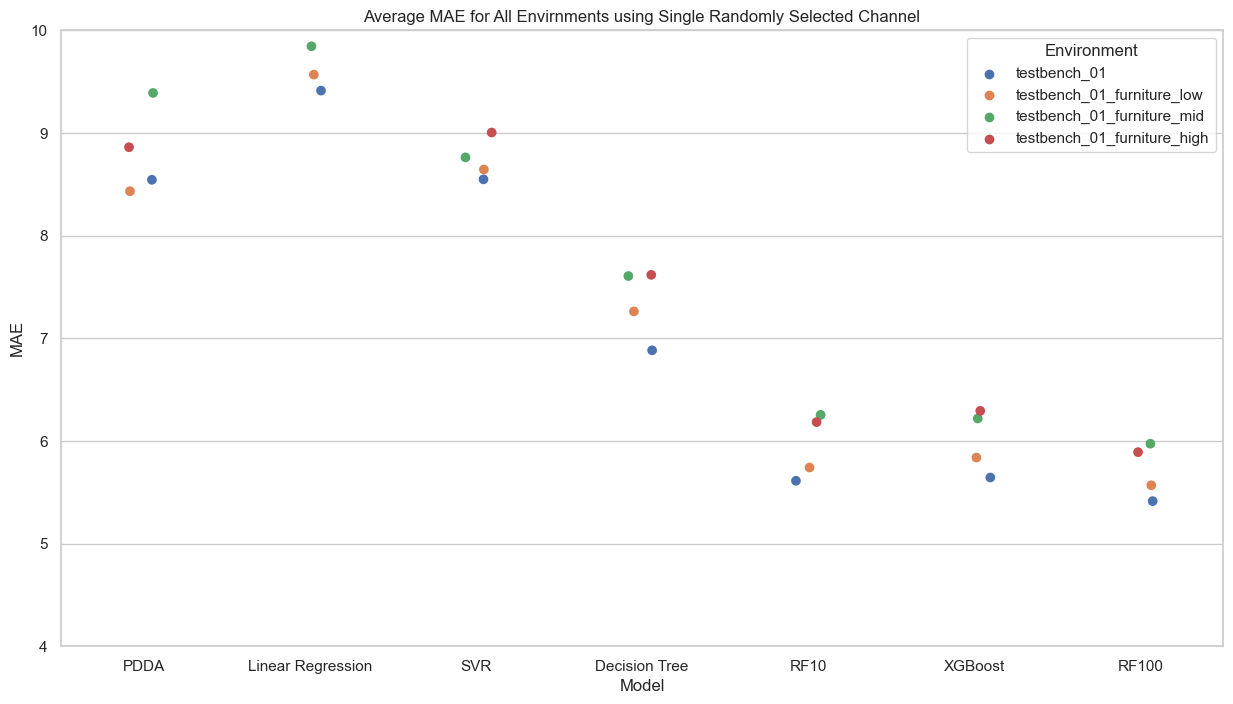

In [6]:
stripplot()

In [ ]:
model_sizes = {"RF100": 1490000 * 0.001, "RF10": 504408 * 0.001, "Decision Tree":  62168 * 0.001, "Linear Regression": 1672 * 0.001, "SVR": 1050000 * 0.001, "XGBoost": 183320* 0.001, "DeepAoANet": 100}


In [69]:
# boxplot for errors
results = results.rename(columns={'MAE_pdda': 'PDDA', 'MAE_RandomForestRegressor()': 'RF100', 
                                  'MAE_RandomForestRegressor(n_estimators=10)': 'RF10', 'MAE_DecisionTreeRegressor()': 'Decision Tree', 
                                  'MAE_KNeighborsRegressor()': 'KNN', "MAE_MLPRegressor()": 'MLP',  "MAE_SVR()": "SVR",
                                 "MAE_GradientBoostingRegressor()": "Gradient Boosting","MAE_XGBRegressor": "XGB","MAE_LinearRegression()": "Linear Regression",})
cols = ["PDDA", "RF100", "RF10", "Decision Tree", "KNN", "MLP", "SVR", "Gradient Boosting", "XGB", "Linear Regression"]
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,8))
ax = sns.boxplot(data=results[cols])
ax.set(ylabel='MAE Error')
plt.savefig('figures/models_boxplot.png')
plt.show()
vv

NameError: name 'results' is not defined

In [95]:
# plot mae vs model size
model_sizes = {"RF100": 1490000 * 0.001, "RF10": 504408 * 0.001, "Decision Tree":  62168 * 0.001, "Linear Regression": 1672 * 0.001, "SVR": 1050000 * 0.001, "XGBoost": 183320* 0.001, "DeepAoANet": 100}
# mae = calculate_mae(results)

In [ ]:
PDDA = 36060(2**(-10))

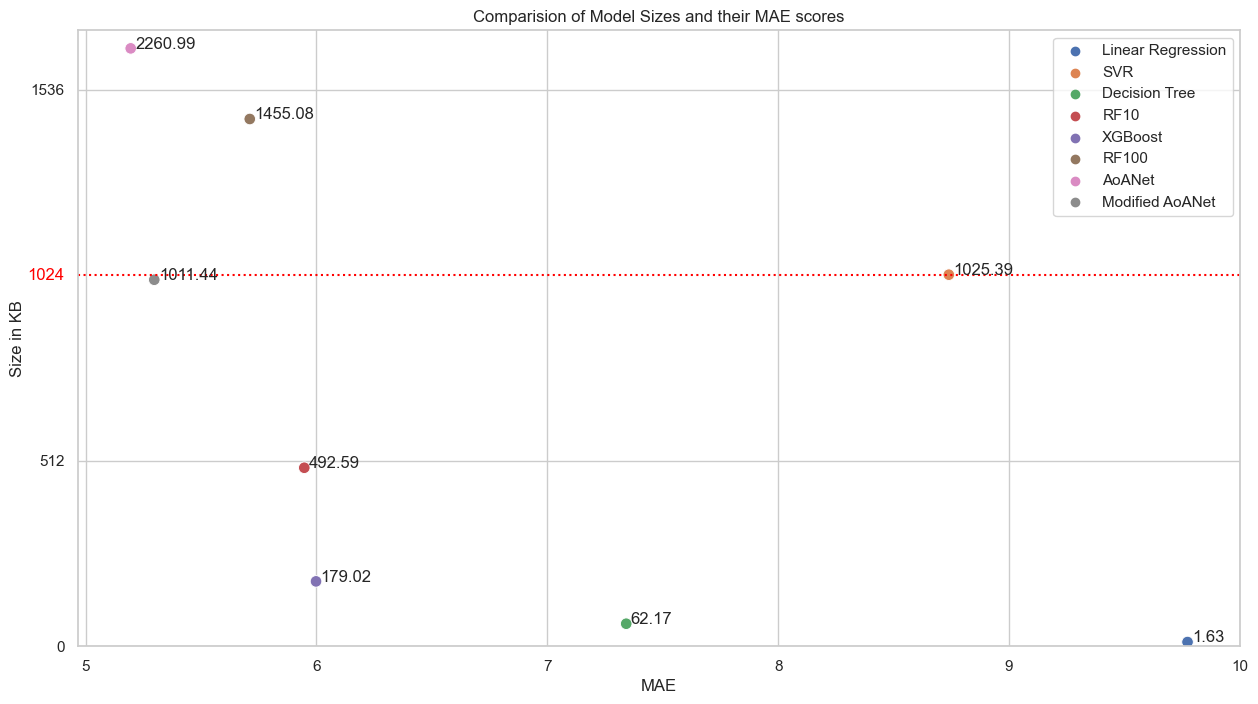

In [7]:
plt.close()
result = pd.read_pickle('results/figure3_panel1.pkl')
result.index = ['PDDA', 'Linear Regression', 'SVR', 'Decision Tree', 'RF10', 'XGBoost', 'RF100', 'AoANet','Modified AoANet']
    
# 1266676 *(2**(-10))+ 1024
model_sizes = {"RF100": 1490000 * (2**(-10)), "RF10": 504408 * (2**(-10)), "Decision Tree":  62168 * 0.001, "Linear Regression": 1672 * (2**(-10))+10, "SVR": 1050000 * (2**(-10)), "XGBoost": 183320* (2**(-10)), "AoANet": 1650, "Modified AoANet":1035716*(2**(-10))}
data = pd.DataFrame.from_dict(model_sizes, orient="index")
temp = pd.DataFrame()
temp['MAE'] = result.mean(axis=1)
merged = pd.concat([temp,data], axis=1)
merged.reset_index(inplace=True)
merged.columns = ["Model","MAE", "Size in KB"]
merged = merged[merged['Size in KB'].notna()]
import matplotlib.transforms as transforms
plt.figure(figsize=(15,8))

ax = sns.scatterplot(data=merged, y="Size in KB", x="MAE", hue ='Model',s=70)
plt.axhline(y=1024, linestyle=':', color='red')
trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0,1024, "{:.0f}".format(1024), color="red", transform=trans, 
        ha="right", va="center")

ax.set_ylim(0, 1700)
# plt.ylim(left=0)

plt.yticks([0,  512, 1536])
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        # print(point['y'] )
        if 1650 <= point['y'] < 1651:
            # print('a')
            # point['val'] = 35.23
            # print(point['y'])
            ax.text(point['x']+.02, 1650, '{0:.2f}'.format((2260.988281)))
        elif 11 <= point['y'] < 12:
            ax.text(point['x']+.02, point['y'], '{0:.2f}'.format(1672 * (2**(-10))))
        else:
            ax.text(point['x']+.02, point['y'], '{0:.2f}'.format((point['val'])))

label_point(merged["MAE"], merged["Size in KB"], merged["Size in KB"], ax)
plt.legend(loc='upper right')
plt.title('Comparision of Model Sizes and their MAE scores')
# ax.set_ylim(bottom=None, top=7)
# plt.ylim(0,1.6)
# plt.savefig("figures/size_performace.pdf", bbox_inches='tight')
# plt.savefig('figures/size_performace.png',format="png")
plt.show()

In [183]:
np.arange(0, 1551, 512)

array([   0,  512, 1024, 1536])

In [478]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [3,5,7,10,15,20,25,30,40,45,50],
    'n_estimators': [2,3,4,5,7,10,15,20,30,50,100]
}# Create a based model

depths = [3,5,7,10,15,20,25,30,40,45,50]
n_estimators = [2,3,4,5,7,10,15,20,30,50,100]
models = []

for depth in param_grid['max_depth']:
    for estimator in param_grid['n_estimators']:
        depths.append(depth)
        n_estimators.append(estimator)
        models.append(RandomForestRegressor(max_depth=depth, n_estimators=estimator))


In [2]:
11*11 +11

132

In [470]:
metrics = [mean_absolute_error, r2_score]

In [36]:
models = [RandomForestRegressor(), RandomForestRegressor(n_estimators=10), DecisionTreeRegressor(), SVR(),
          xgb.XGBRegressor(),LinearRegression()]
metrics = [mean_absolute_error, r2_score]

In [37]:
results, anchor_mae, pdda_error, trained_models = train(mid, models, metrics)

RandomForestRegressor()
RandomForestRegressor(n_estimators=10)
DecisionTreeRegressor()
SVR()
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)
LinearRegression()


In [39]:
import sys

sys.setrecursionlimit(2147483647)

In [40]:
def convert_models(trained_models):
    
    for model_name,model in trained_models.items():
        try:
            code = m2c.export_to_c(model)
            with open('converted_models/singlechannel/'+model_name+'.h', 'w') as file:
                # file.write(port(model))
                 file.write(code)
        except Exception as e:
            print("could not convert "+model_name)
            print(e)

In [41]:
convert_models(trained_models)

In [482]:
maes = []

for i in range(len(depths)):
    depth = depths[i]
    estimator = n_estimators[i]
    if estimator != 100:
        maes.append(mean_absolute_error(results['RandomForestRegressor(max_depth='+str(depth)+', n_estimators='+str(estimator)+')'], results['true_phi']))
    else:
        maes.append(mean_absolute_error(results['RandomForestRegressor(max_depth='+str(depth)+')'], results['true_phi']))

                        
                        
                        

In [509]:
hyperparameter = pd.DataFrame()

In [511]:
hyperparameter['tree_depth'] = depths
hyperparameter['estimators'] = n_estimators
hyperparameter['mae'] = maes

In [513]:
hyperparameter = hyperparameter.sort_values(by=['mae'])

In [518]:
# hyperparameter.head(100)

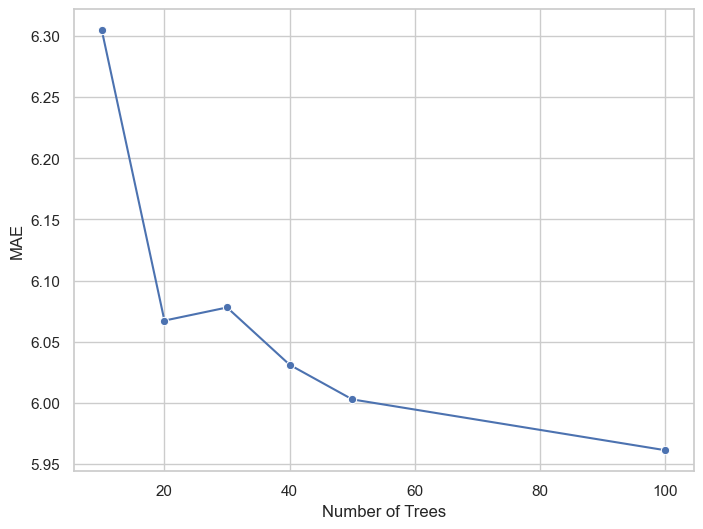

In [45]:
x = [10,20,30,40,50,100]
y = [] 
y.append(mae['RF10'])
y.append(mae['RF20'])
y.append(mae['RF30'])
y.append(mae['RF40'])
y.append(mae['RF50'])
y.append(mae['RF100'])
plt.figure(figsize=(8,6))
ax = sns.lineplot(x=x, y=y,  marker="o", markers=True)
ax.set(xlabel='Number of Trees')
ax.set(ylabel='MAE')
plt.savefig("figures/mae_trees.pdf", bbox_inches='tight')
plt.savefig("figures/mae_trees.png")
plt.show()

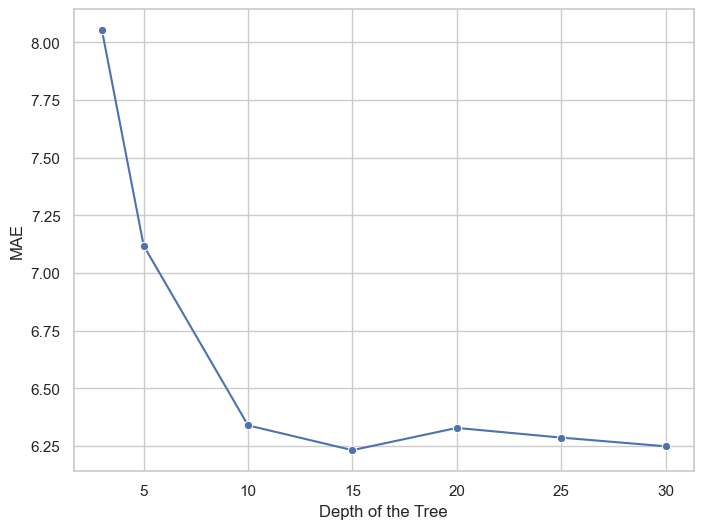

In [46]:
x = [3,5,10,15,20,25,30]
y = [] 
y.append(mae['RFm3'])
y.append(mae['RFm5'])
y.append(mae['RFm10'])
y.append(mae['RFm15'])
y.append(mae['RFm20'])
y.append(mae['RFm25'])
y.append(mae['RFm30'])
plt.figure(figsize=(8,6))
ax = sns.lineplot(x=x, y=y,  marker="o", markers=True)
ax.set(xlabel='Depth of the Tree')
ax.set(ylabel='MAE')
plt.savefig("figures/mae_depth.png")
plt.show()

In [481]:
len(n_estimators)

132

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


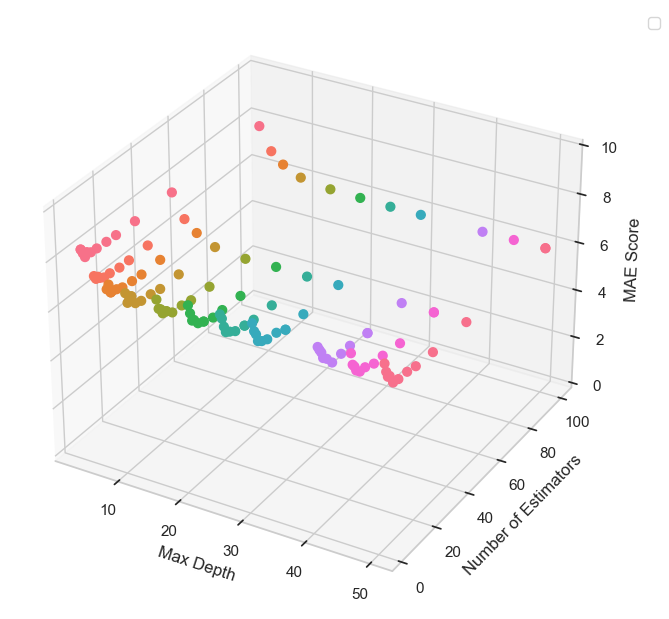

In [508]:
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# generate data
n = 200
x = depths
y = n_estimators
z = maes

# axes instance
fig = plt.figure(figsize=(10,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=x, marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('Max Depth')
ax.set_ylabel('Number of Estimators')
ax.set_zlabel('MAE Score')
ax.set_zlim(0,10)

# legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig('figures/hyperparameters.png',format="png")

In [163]:
def plot_room():
    """"""
    model_names = ["pdda","RandomForestRegressor()", "RandomForestRegressor(n_estimators=10)", "DecisionTreeRegressor()", 
                   "KNeighborsRegressor()", "MLPRegressor()", "GradientBoostingRegressor()", "XGBRegressor"]
    for model in model_names:
        results[model] = results.apply(lambda row: mean_absolute_error([row[model]], [row['true_phi']]), axis=1) 
        spatial_plot(results[model], results['x_loc'], results['y_loc'], 'pdda_room_'+model+'.png', 'MAE scores for '+model, vmax=10, anchors=[1])
    return

In [ ]:
# plot_room()

In [54]:
import sys

sys.setrecursionlimit(2147483647)

In [55]:
def convert_models(trained_models):
    
    for model_name,model in trained_models.items():
        try:
            code = m2c.export_to_c(model)
            with open('converted_models/'+model_name+'.h', 'w') as file:
                # file.write(port(model))
                 file.write(code)
        except Exception as e:
            print("could not convert "+model_name)
            print(e)

In [56]:
convert_models(trained_models)

could not convert KNeighborsRegressor()
Model 'sklearn_KNeighborsRegressor' is not supported
could not convert MLPRegressor()
Model 'sklearn_MLPRegressor' is not supported
could not convert GradientBoostingRegressor()
Model 'sklearn_GradientBoostingRegressor' is not supported
